In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.io import imread, imsave
from skimage.transform import resize
import os
import numpy as np
import cv2

import pyBaseRadii as pyBR

MIXED_DIR = r"D:\data\mixed"

## Base radii: Projection Features

Code for projection feature dump into separate file.

In [3]:
features = list()
targets = list()
eye_data = list()
names = list()
src_list = list()

with open(r"D:\data\BaseRadii\ProjectionFeatures7.csv", 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = str(line).strip('\\r\\n')
        data = data.strip('\r')
        data = data.strip('\n')
        data = data.split(',')
        proj_data = list(map(lambda x: int(x), data[4:-2]))
        
        if len(proj_data) == 640:
            name = data[0]
            src = imread(os.path.join(MIXED_DIR, name), as_grey=True).astype(np.uint8)
            src_list.append(src)
            
            cenX, cenY, maxRad = int(data[1]), int(data[2]), int(data[3])
            _eye_data = dict(name=name,x=cenX,y=cenY,maxRad=maxRad)
            eye_data.append(_eye_data)
            
            features.append(proj_data)
            targets.append([int(data[-2].strip('\r\n')),int(data[-1])])
            names.append([name])
        
print(len(features[0]), targets[0])

640 [54, 128]


### Original method experiments

#### Unit test

In [78]:
thr_horiz = 0
thr_dot = .5
ang_min, ang_max = -5, 55
kernel = np.array([-3,0,3,-10,0,10,-3,0,3])

data_dir = MIXED_DIR

In [ ]:
def plot_br_detection(i):
    src = src_list[i]
    h_,w_ = src.shape
    
    cx, cy = eye_data[i]['x'],  eye_data[i]['y']
    min_r, max_r = min(h_,w_)//10, max(h_,w_)//2
    br_est = pyBR.BaseRadiiEst(kernel, ang_min, ang_max, min_r, max_r, thr_horiz, thr_dot)
    src_ = cv2.equalizeHist(np.copy(src))
    det_eye_params, pr_l, pr_r = br_est.process_img(src, cx, cy)
    xp,yp,rp,xi,yi,ri = det_eye_params
    print(cx,cy)
    print(rp, ri)
    print(xp,yp, xi,yi)
    _pupil = plt.Circle((xp,yp), radius=rp, fill=False, color='r')
    _iris = plt.Circle((xi,yi), radius=ri, fill=False, color='b')
    plt.subplot(131)
    plt.imshow(src, cmap='gray')
    ax=plt.gca()
    ax.add_artist(_pupil)
    ax.add_artist(_iris)
    plt.subplot(132)
    plt.plot(pr_l)
    plt.subplot(133)
    plt.plot(pr_r)
    plt.gcf().set_size_inches(12,4)
    
interact(plot_br_detection, i=widgets.IntSlider(min=0,max=len(features),step=1,value=3))

#### Common presets

In [69]:
error_quantile_single = 0.1
error_quantile_both = 0.2

get_radii_quality = lambda rp,ri,rp_gt,ri_gt: (abs(rp-rp_gt) + abs(ri - ri_gt)) / ri_gt
get_iris_quality = lambda ri, ri_gt: abs(ri - ri_gt) / ri_gt
get_pupil_quality = lambda rp, rp_gt,ri_gt: abs(rp - rp_gt) / ri_gt
data_dir = r"D:\data\mixed"

#### Find best thresholds

In [71]:
def base_radii_thr_experiment_eval(eye_data, targets, thr_horiz_range, thr_dot_range):
    ang_min, ang_max = -45, 45
    kernel = np.array([-1,0,1,-2,0,2,-1,0,1])
    
    ret_table = np.zeros((len(thr_horiz_range), len(thr_dot_range)))
    ret_table_p = np.zeros((len(thr_horiz_range), len(thr_dot_range)))
    ret_table_i = np.zeros((len(thr_horiz_range), len(thr_dot_range)))
    ret_outliers_p = np.zeros((len(thr_horiz_range), len(thr_dot_range)))
    ret_outliers_i = np.zeros((len(thr_horiz_range), len(thr_dot_range)))
    
    for i, t_h in enumerate(thr_horiz_range):
        for j, t_dot in enumerate(thr_dot_range):
            for k, eye_d in enumerate(eye_data):
                rp_gt, ri_gt = targets[k]
                src = src_list[k] # imread(os.path.join(data_dir, eye_d['name']), as_grey=True).astype(np.uint8)
                h_,w_ = src.shape
    
                cx, cy = eye_d['x'],  eye_d['y']
                min_r, max_r = min(h_,w_)//20, max(h_,w_)//2
                br_est = pyBR.BaseRadiiEst(kernel, ang_min, ang_max, min_r, max_r, t_h, t_dot)
                det_eye_params, pr_l, pr_r = br_est.process_img(src, cx, cy)
                
                xp,yp,rp,xi,yi,ri = det_eye_params
                if rp > 0 or ri > 0:
                    if rp == -1:
                        ret_outliers_p[i,j] +=1
                        ret_table_i[i,j] += (get_iris_quality(ri, ri_gt) <= error_quantile_single)
                    elif ri == -1:
                        ret_outliers_i[i,j] +=1
                        ret_table_p[i,j] += (get_pupil_quality(rp, rp_gt, ri_gt) <= error_quantile_single)
                    else:
                        ret_table[i,j] += (get_radii_quality(rp,ri,rp_gt, ri_gt) <= error_quantile_both)
                        ret_table_p[i,j] += (get_pupil_quality(rp, rp_gt, ri_gt) <= error_quantile_single)
                        ret_table_i[i,j] += (get_iris_quality(ri, ri_gt) <= error_quantile_single)
                else:
                    ret_outliers_i[i,j] +=1
                    ret_outliers_p[i,j] +=1
            
            q = ret_table[i,j]/len(eye_data)
            q_p = ret_table_p[i,j]/(len(eye_data) - ret_outliers_p[i,j])
            q_i = ret_table_i[i,j]/(len(eye_data) - ret_outliers_i[i,j])
            
            print('Eval: thr_horiz:{} | thr_dot:{:.2f} | Q: {:.4} | Q_p: {:.4} | Q_i: {:.4}.'.format(t_h, t_dot, q, q_p, q_i))
    
    ret = (thr_horiz_range, thr_dot_range, ret_table, ret_table_p, ret_table_i, ret_outliers_p, ret_outliers_i)
    return ret

In [60]:
%%time
ans_tup = base_radii_experiment_eval(eye_data, targets)

Eval: thr_horiz:0 | thr_dot:0.50 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.55 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.60 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.65 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.70 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.75 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.80 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.85 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.90 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:0 | thr_dot:0.95 | Q: 0.847 | Q_p: 0.747 | Q_i: 0.99.
Eval: thr_horiz:1 | thr_dot:0.50 | Q: 0.862 | Q_p: 0.806 | Q_i: 0.995.
Eval: thr_horiz:1 | thr_dot:0.55 | Q: 0.862 | Q_p: 0.806 | Q_i: 0.995.
Eval: thr_horiz:1 | thr_dot:0.60 | Q: 0.862 | Q_p: 0.806 | Q_i: 0.995.
Eval: thr_horiz:1 | thr_dot:0.65 | Q: 0.862 | Q_p: 0.806 | Q_i: 0.995.
Eval: thr_horiz:

In [ ]:
thr_horiz_range, thr_dot_range, ret_table, ret_table_p, ret_table_i, ret_outliers_p, ret_outliers_i = ans_tup
print(ret_table[:,1] / len(eye_data))
print(ret_table_p[:,1] / len(eye_data))
print(ret_table_i[:,1] / len(eye_data))
print(thr_horiz_range)

In [73]:
thr_horiz_range = np.arange(0,9,1)
thr_dot_range = np.arange(0.94,0.99,0.02)
ans_tup_smaller_range = base_radii_thr_experiment_eval(eye_data, targets, thr_horiz_range, thr_dot_range)

Eval: thr_horiz:0 | thr_dot:0.94 | Q: 0.8525 | Q_p: 0.75 | Q_i: 0.9896.
Eval: thr_horiz:0 | thr_dot:0.96 | Q: 0.8525 | Q_p: 0.75 | Q_i: 0.9896.
Eval: thr_horiz:0 | thr_dot:0.98 | Q: 0.8525 | Q_p: 0.75 | Q_i: 0.9896.
Eval: thr_horiz:1 | thr_dot:0.94 | Q: 0.8696 | Q_p: 0.8057 | Q_i: 0.9951.
Eval: thr_horiz:1 | thr_dot:0.96 | Q: 0.8696 | Q_p: 0.8057 | Q_i: 0.9951.
Eval: thr_horiz:1 | thr_dot:0.98 | Q: 0.8696 | Q_p: 0.8057 | Q_i: 0.9951.
Eval: thr_horiz:2 | thr_dot:0.94 | Q: 0.8617 | Q_p: 0.8133 | Q_i: 0.9973.
Eval: thr_horiz:2 | thr_dot:0.96 | Q: 0.8617 | Q_p: 0.8133 | Q_i: 0.9973.
Eval: thr_horiz:2 | thr_dot:0.98 | Q: 0.8617 | Q_p: 0.8133 | Q_i: 0.9973.
Eval: thr_horiz:3 | thr_dot:0.94 | Q: 0.8538 | Q_p: 0.8184 | Q_i: 0.9978.
Eval: thr_horiz:3 | thr_dot:0.96 | Q: 0.8538 | Q_p: 0.8184 | Q_i: 0.9978.
Eval: thr_horiz:3 | thr_dot:0.98 | Q: 0.8538 | Q_p: 0.8184 | Q_i: 0.9978.
Eval: thr_horiz:4 | thr_dot:0.94 | Q: 0.8464 | Q_p: 0.8243 | Q_i: 0.9987.
Eval: thr_horiz:4 | thr_dot:0.96 | Q: 0.8464

#### Find best angles

In [86]:
min_angle_diff = 20 # minimal angle difference should be not very low
ang_beg_limit = -60       # upper eyelid is often half-closed
ang_end_limit = 89        # lower eyelid is opened more often

def base_radii_angle_experiment_eval(eye_data, targets, ang_beg_range, ang_end_range):
    # acquired after the evaluation of base_radii_thr_experiment_eval()
    t_h, t_dot = 2, 0.95
    kernel = np.array([-1,0,1,-2,0,2,-1,0,1])
    
    ret_table = np.zeros((len(ang_beg_range), len(ang_end_range)))
    ret_table_p = np.zeros((len(ang_beg_range), len(ang_end_range)))
    ret_table_i = np.zeros((len(ang_beg_range), len(ang_end_range)))
    ret_outliers_p = np.zeros((len(ang_beg_range), len(ang_end_range)))
    ret_outliers_i = np.zeros((len(ang_beg_range), len(ang_end_range)))
    
    for i, a_beg in enumerate(ang_beg_range):
        for j, a_end in enumerate(ang_end_range):
            if a_end - a_beg < min_angle_diff: continue
            for k, eye_d in enumerate(eye_data):
                rp_gt, ri_gt = targets[k]
                src = src_list[k] # imread(os.path.join(data_dir, eye_d['name']), as_grey=True).astype(np.uint8)
                h_,w_ = src.shape
    
                cx, cy = eye_d['x'], eye_d['y']
                min_r, max_r = min(h_,w_)//20, max(h_,w_)//2
                br_est = pyBR.BaseRadiiEst(kernel, a_beg, a_end, min_r, max_r, t_h, t_dot)
                det_eye_params, pr_l, pr_r = br_est.process_img(src, cx, cy)
                
                xp,yp,rp,xi,yi,ri = det_eye_params
                if rp > 0 or ri > 0:
                    if rp == -1:
                        ret_outliers_p[i,j] +=1
                        ret_table_i[i,j] += (get_iris_quality(ri, ri_gt) <= error_quantile_single)
                    elif ri == -1:
                        ret_outliers_i[i,j] +=1
                        ret_table_p[i,j] += (get_pupil_quality(rp, rp_gt, ri_gt) <= error_quantile_single)
                    else:
                        ret_table[i,j] += (get_radii_quality(rp,ri,rp_gt, ri_gt) <= error_quantile_both)
                        ret_table_p[i,j] += (get_pupil_quality(rp, rp_gt, ri_gt) <= error_quantile_single)
                        ret_table_i[i,j] += (get_iris_quality(ri, ri_gt) <= error_quantile_single)
                else:
                    ret_outliers_i[i,j] +=1
                    ret_outliers_p[i,j] +=1
            
            q = ret_table[i,j]/len(eye_data)
            q_p = ret_table_p[i,j]/(len(eye_data) - ret_outliers_p[i,j])
            q_i = ret_table_i[i,j]/(len(eye_data) - ret_outliers_i[i,j])
            
            print('Eval: a_beg:{:2.0f} | a_end:{:3.0f} | Q: {:.4} | Q_p: {:.4} | Q_i: {:.4}.'.format(a_beg, a_end, q, q_p, q_i))
    
    ret = (ret_table, ret_table_p, ret_table_i, ret_outliers_p, ret_outliers_i)
    return ret

In [88]:
ang_beg_range = np.arange(ang_beg_limit, ang_end_limit-min_angle_diff, 5)
ang_end_range = np.arange(ang_beg_limit-min_angle_diff, ang_end_limit, 5)
angle_ans_tuple = base_radii_angle_experiment_eval(eye_data, targets, ang_beg_range, ang_end_range)

Eval: a_beg:-60 | a_end:-40 | Q: 0.3978 | Q_p: 0.7329 | Q_i: 0.5105.
Eval: a_beg:-60 | a_end:-35 | Q: 0.4171 | Q_p: 0.7398 | Q_i: 0.5773.
Eval: a_beg:-60 | a_end:-30 | Q: 0.4516 | Q_p: 0.753 | Q_i: 0.6459.
Eval: a_beg:-60 | a_end:-25 | Q: 0.4893 | Q_p: 0.7577 | Q_i: 0.7083.
Eval: a_beg:-60 | a_end:-20 | Q: 0.5269 | Q_p: 0.7604 | Q_i: 0.7639.
Eval: a_beg:-60 | a_end:-15 | Q: 0.5641 | Q_p: 0.7716 | Q_i: 0.8052.
Eval: a_beg:-60 | a_end:-10 | Q: 0.6254 | Q_p: 0.7736 | Q_i: 0.8471.
Eval: a_beg:-60 | a_end: -5 | Q: 0.6735 | Q_p: 0.7768 | Q_i: 0.8864.
Eval: a_beg:-60 | a_end:  0 | Q: 0.7199 | Q_p: 0.7862 | Q_i: 0.9242.
Eval: a_beg:-60 | a_end:  5 | Q: 0.7545 | Q_p: 0.7875 | Q_i: 0.9485.
Eval: a_beg:-60 | a_end: 10 | Q: 0.7926 | Q_p: 0.7888 | Q_i: 0.9625.
Eval: a_beg:-60 | a_end: 15 | Q: 0.8175 | Q_p: 0.7929 | Q_i: 0.974.
Eval: a_beg:-60 | a_end: 20 | Q: 0.8333 | Q_p: 0.7977 | Q_i: 0.983.
Eval: a_beg:-60 | a_end: 25 | Q: 0.8442 | Q_p: 0.7971 | Q_i: 0.9832.
Eval: a_beg:-60 | a_end: 30 | Q: 0.85

Eval: a_beg:-35 | a_end:-15 | Q: 0.667 | Q_p: 0.7542 | Q_i: 0.8275.
Eval: a_beg:-35 | a_end:-10 | Q: 0.7059 | Q_p: 0.7621 | Q_i: 0.8776.
Eval: a_beg:-35 | a_end: -5 | Q: 0.7479 | Q_p: 0.7705 | Q_i: 0.9148.
Eval: a_beg:-35 | a_end:  0 | Q: 0.779 | Q_p: 0.7747 | Q_i: 0.9285.
Eval: a_beg:-35 | a_end:  5 | Q: 0.8079 | Q_p: 0.7874 | Q_i: 0.9579.
Eval: a_beg:-35 | a_end: 10 | Q: 0.8276 | Q_p: 0.7938 | Q_i: 0.9704.
Eval: a_beg:-35 | a_end: 15 | Q: 0.8389 | Q_p: 0.7957 | Q_i: 0.9765.
Eval: a_beg:-35 | a_end: 20 | Q: 0.8473 | Q_p: 0.8028 | Q_i: 0.9824.
Eval: a_beg:-35 | a_end: 25 | Q: 0.8521 | Q_p: 0.8051 | Q_i: 0.9874.
Eval: a_beg:-35 | a_end: 30 | Q: 0.8534 | Q_p: 0.8071 | Q_i: 0.9919.
Eval: a_beg:-35 | a_end: 35 | Q: 0.8538 | Q_p: 0.811 | Q_i: 0.9928.
Eval: a_beg:-35 | a_end: 40 | Q: 0.8569 | Q_p: 0.8157 | Q_i: 0.9964.
Eval: a_beg:-35 | a_end: 45 | Q: 0.8573 | Q_p: 0.8164 | Q_i: 0.9973.
Eval: a_beg:-35 | a_end: 50 | Q: 0.8556 | Q_p: 0.8223 | Q_i: 0.9973.
Eval: a_beg:-35 | a_end: 55 | Q: 0.85

Eval: a_beg:-5 | a_end: 60 | Q: 0.835 | Q_p: 0.8434 | Q_i: 0.9991.
Eval: a_beg:-5 | a_end: 65 | Q: 0.8407 | Q_p: 0.8385 | Q_i: 0.9982.
Eval: a_beg:-5 | a_end: 70 | Q: 0.8425 | Q_p: 0.8361 | Q_i: 0.9991.
Eval: a_beg:-5 | a_end: 75 | Q: 0.8398 | Q_p: 0.834 | Q_i: 0.9978.
Eval: a_beg:-5 | a_end: 80 | Q: 0.8442 | Q_p: 0.8327 | Q_i: 0.9982.
Eval: a_beg:-5 | a_end: 85 | Q: 0.8473 | Q_p: 0.8323 | Q_i: 0.9987.
Eval: a_beg: 0 | a_end: 20 | Q: 0.7987 | Q_p: 0.7563 | Q_i: 0.9072.
Eval: a_beg: 0 | a_end: 25 | Q: 0.8114 | Q_p: 0.7649 | Q_i: 0.9281.
Eval: a_beg: 0 | a_end: 30 | Q: 0.8276 | Q_p: 0.7958 | Q_i: 0.9692.
Eval: a_beg: 0 | a_end: 35 | Q: 0.8306 | Q_p: 0.8078 | Q_i: 0.9891.
Eval: a_beg: 0 | a_end: 40 | Q: 0.8333 | Q_p: 0.8184 | Q_i: 0.9937.
Eval: a_beg: 0 | a_end: 45 | Q: 0.8372 | Q_p: 0.8266 | Q_i: 0.9955.
Eval: a_beg: 0 | a_end: 50 | Q: 0.8341 | Q_p: 0.8311 | Q_i: 0.9969.
Eval: a_beg: 0 | a_end: 55 | Q: 0.8306 | Q_p: 0.8396 | Q_i: 0.9978.
Eval: a_beg: 0 | a_end: 60 | Q: 0.8337 | Q_p: 0.83

### Restore experiment data

In [25]:
import pandas as pd
a = pd.read_csv(r"D:\data\BaseRadii\ExperimentAngle.csv")
a = np.array(a)

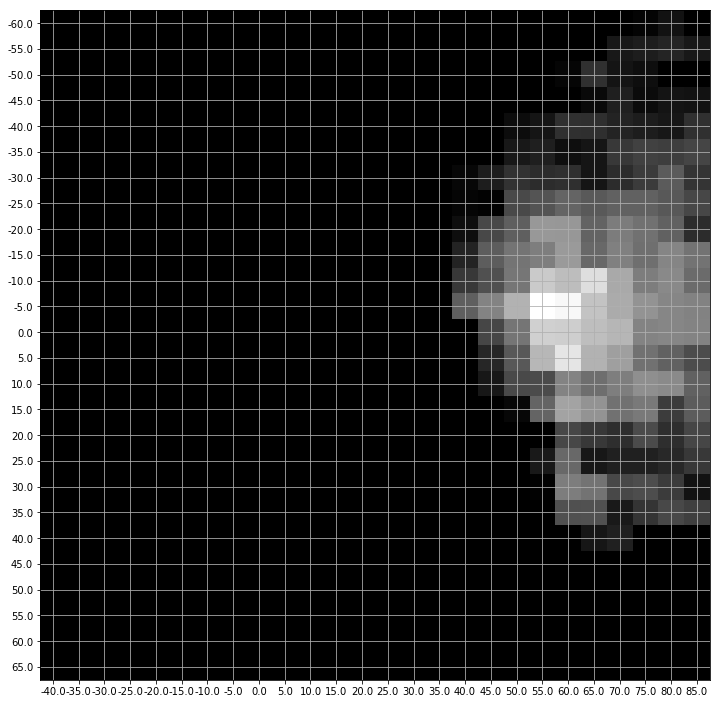

In [77]:
a_beg_x = a[:,0]
a_beg_values = sorted(list(set(a_beg_x)))
a_beg_range = len(set(a_beg_x))
a_beg_dict = dict(zip(a_beg_values, range(a_beg_range)))
a_end_y = a[:,1]
a_end_values = sorted(list(set(a_end_y)))
a_end_range = len(set(a_end_y))
a_end_dict = dict(zip(a_end_values, range(a_end_range)))
quality_threshold = 0.82
res = np.zeros((a_beg_range, a_end_range))
for i in range(a.shape[0]):
    res[a_beg_dict[a[i,0]], a_end_dict[a[i,1]]] = 255 * a[i,3] * (a[i,3] > quality_threshold)

plt.imshow(res, cmap='gray', vmin=255 * quality_threshold)
plt.grid()
xt = plt.xticks(list(range(a_end_range)), list(a_end_dict.keys()))
yt = plt.yticks(list(range(a_beg_range)), list(a_beg_dict.keys()))
plt.gcf().set_size_inches(12,18)

Rough report:
* Optimal angles for base radii estimation are from -5 to 55 degrees, considering pupil segmentation accuracy.
* It gives 84,41% quality for pupil segmentation and 99,78% for iris segmentation.
* It is good to change segmentation quality estimation for both edges.